In [21]:
%matplotlib inline


In [22]:
!pwd

/home/mirwox/robot/src/particlefilter


In [23]:
# Dados do arquivo mapa.yaml

resolution = 0.020000
origin =  [-5.000000, -5.000000, 0.000000]
occupied_thresh = 0.65
free_thresh =  0.196


In [24]:
from random import randint, choice
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import math
import random
from pf import Particle
from nav_msgs.msg import OccupancyGrid
from occupancy_field import OccupancyField
from helper_functions import angle_normalize, angle_diff


from PIL import Image as PilImage
pil_image = PilImage.open("scaled_map.pgm", 'r')
np_image = np.asarray(pil_image)

particle_size = 10

#import matplotlib_render as plotmap


back_color = "black"
colors     = ['red', 'green', 'cyan', 'yellow']
width, height = 480, 480

initial_pose = [200, 200, math.pi/8] # Posicao inicial considerada para o pf
pose = [320, 250, math.radians(90)] # posicao "verdadeira" do robo 
robot_radius=10   # Raio do robo

# Os angulos em que o robo simulado vai ter sensores
angles = np.linspace(0.0, 2*math.pi, num=8)

particle_cloud = []

def convert_to_figure(xy_theta):
    """ 
        Converts a xy_theta to screen coordinates
    """
    pass


def nb_draw_map(mapa_numpy, particles = None, initial_position=False, pose=False, robot=False):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set(xlim=[0, width], ylim=[0, height]) # Or use "ax.axis([x0,x1,y0,y1])"

    fig.canvas.draw()

    #def update():

    plt.imshow(mapa_numpy, cmap='Greys_r')
    if initial_position:
        draw_initial_pose(initial_pose,ax)
    if particles:
        nb_draw_particle_cloud(particles, ax)
    if pose:
        nb_draw_arrow(pose[0], pose[1], pose[2], ax, color='g', width=2, headwidth=6, headlength=6)
    if robot:
        nb_draw_robot(pose, ax, radius=robot_radius)
    
    return ax # Retornamos o contexto grafico caso queiram fazer algo depois

        
def draw_initial_pose(pose_xytheta, ax):
    """
        Metodo que desenha a pose inicial
        pose - um array que contem x, y e theta da pose inicial
        ax - um objeto do matplotlib
    """
    x = pose_xytheta[0]
    y = pose_xytheta[1]
    theta = pose_xytheta[2]
    l = 15
    #end_x = x + deltax
    #end_y = y + deltay
    nb_draw_arrow(x, y, theta, ax, l=l, color='r', width=2, headwidth=6, headlength=6)
    
def nb_draw_arrow(x, y, theta, ax, l = 15, color='y', headwidth=3.0, headlength=3, width=0.001):
    deltax = l*math.cos(theta)
    deltay = l*math.sin(theta)
    ax.arrow(x, y, deltax, deltay, head_width=headwidth, head_length=headlength, fc=color,  ec=color, width=width)

def nb_draw_particle_cloud(particles, ax):
    """
        Desenha o particle cloud
        particles - uma lista de objetos Particle
        ax - eixo
    """
    for p in particles:
        nb_draw_arrow(p.x, p.y, p.theta, ax, particle_size, color='b')

def normalize_particles():
    #global particle_cloud
    w_sum = 0
    for p in particle_cloud:
        w_sum+=p.w
    for p in particle_cloud:
        p.normalize(w_sum)

def update_robot_pose():
    """ Update the estimate of the robot's pose given the updated particles.
        There are two logical methods for this:
            (1): compute the mean pose
            (2): compute the most likely pose (i.e. the mode of the distribution)
    """
    # first make sure that the particle weights are normalized
    normalize_particles()

    # TODO: assign the lastest pose into self.robot_pose as a geometry_msgs.Pose object
    # Nota: neste notebook ao inves de usarmos um objeto Pose vou usar uma lista x, y, theta
    robot_pose = [0, 0, 0]
        
def nb_initialize_particle_cloud(xy_theta=None):
    """ Initialize the particle cloud.
        Arguments
        xy_theta: a triple consisting of the mean x, y, and theta (yaw) to initialize the
                  particle cloud around.  If this input is ommitted, the odometry will be used """
    if xy_theta == None:
        #xy_theta = convert_pose_to_xy_and_theta(.odom_pose.pose)
        pass
    global particle_cloud
    # TODO create particles
    particle_cloud = nb_create_particles(initial_pose)
        
    normalize_particles()
    update_robot_pose()    
    
def nb_create_particles(pose, var_x = 50, var_y = 50, var_theta = math.pi/3, num=30):
    """
        Cria num particulas
        situadas no intervalo x - var_x a x + var_x, y - var_x at'e y + var_y e theta - var_theta a theta + var_theta
    """
    particle_cloud = []
    s = pose
    for i in range(num):
        x = random.uniform(s[0] - var_x, s[0] + var_x)
        y = random.uniform(s[1] - var_x, s[1] + var_y)
        theta = random.uniform(s[2] - var_theta, s[2] + var_theta)
        p = Particle(x, y, theta, w=1.0) # A prob. w vai ser normalizada depois
        particle_cloud.append(p)
    return particle_cloud

def nb_draw_robot(position, ax, radius=10):
    from matplotlib.patches import Circle
    circle = Circle((position[0], position[1]), radius, facecolor='none',
                    edgecolor=(0.0, 0.8, 0.2), linewidth=2, alpha=0.7)
    ax.add_patch(circle)
    
def nb_create_ros_map(numpy_image):
    """
        Este notebook nao usa o service GetMap, portanto
        precisamos usar a imagem que foi lida e criar um OccupancyGrid
    """
    grid = OccupancyGrid()
    grid.info.resolution = 1
    w = numpy_image.shape[0]
    h = numpy_image.shape[1]    
    grid.info.width = w
    grid.info.height = h
    image_data = []
    for i in range(numpy_image.size):
        cell = 1.0 - (numpy_image[i//w][i%w]/255.0)
        if cell < 0.005:
            cell = 0
        image_data.append(cell)
    
    print("Occurences of zero",image_data.count(0))
    grid.data = image_data
    return grid

def nb_interp(min_a, max_a, a, dst_min, dst_max):
    """
        Funcao de interpolacao generica.
        min_a
        max_a
        a - valor na faixa de origem
        dst_min, dst_max - a faixa de destino
    """    
    return dst_min + ((a - min_a)/(max_a - min_a))*(dst_max - dst_min)

def nb_cria_occupancy_field_image(occupancy_field, numpy_image):
    occupancy_image = numpy_image.copy() # todo: extrair do occupancy_grid no futuro
    max_dist = max(occupancy_field.closest_occ.values())
    min_dist = min(occupancy_field.closest_occ.values())
    for i in range(occupancy_image.shape[1]):
        for j in range(occupancy_image.shape[0]):
            occupancy_image[i][j] = int(nb_interp(min_dist, max_dist, occupancy_field.get_closest_obstacle_distance(j,i), 0, 255))
    return occupancy_image
   



def nb_outside_image(x, y, img):
    if x > img.shape[1] or x < 0:
        return true
    if y > img.shape[0] or y < 0:
        return ture

def nb_found_obstacle(x, y, x0, y0, img):
    gray_value = 1.0 - img[x][y]/255.0
    if gray_value > free_thresh and gray_value < occupied_thresh:
        return math.sqrt( (x0 - x)**2 + (y0 - x)**2 )

        
    
def nb_find_discrete_line_versor(xa, ya, angle):
    m = math.tan(angle)
    delta = 50.0 # arbitrario
    xd = xa + delta*math.cos(angle)
    yd = ya + delta*math.sin(angle)
    deltay = yd - ya
    deltax = xd - xa
    v = [deltax, deltay]
    length = math.sqrt(deltax**2 + deltay**2)
    versor = [deltax/delta, deltay/delta]
    # Um pouco ineficiente mas 'garante' que nao pularemos celular
    for i in range(len(versor)):
        versor[i]*=0.6
    return versor
    


def nb_simulate_lidar(robot_pose, angles, img):
    """
        Simula a leitura `real` do LIDAR supondo que o robot esteja na robot_pose e com sensores nos angulos angles
        
        Nao e' necessario fazer isso em seu projeto
        
        retorna uma lista de pontos de intersecao ou -1 se o sensor nao ler nada naquele angulo
        
    """
    a = angles.copy()
    theta = 2 # para ficar mais intuitivo
    
    #robot_pose[theta] = angle_normalize(robot_pose[theta])
    
    lidar_results = {}
    
    result_img = np.zeros(img.shape)
    result_img.fill(255) # Deixamos tudo branco
    
    x0 = robot_pose[0]
    y0 = robot_pose[1]
    
    for angulo in a:
        # Faz o angulo ser relativo ao robo
        ang = robot_pose[theta]+angulo
        print("Angle ", ang)
        xa, ya = x0, y0
        x = xa
        y = ya
        vers = nb_find_discrete_line_versor(xa, ya, ang)
        #print("vers ", ang, "  " , vers)

        while (True):
            result_img[int(y), int(x)] = 0 # Marcamos o raio na imagem y,x porque numpy e' linha, coluna
            if nb_outside_image(int(x), int(y), img):
                # A imagem acabou, nao achamos nada
                lidar_results[ang] = -1   
                print("Outside at ",x ,"  ",y, "  for angle ", ang)
                break
            dist = nb_found_obstacle(int(y), int(x), y0, x0, img)
            if dist > -1:   
                # Achamos alguma coisa
                lidar_results[ang] = dist 
                print("Hit for ",x,  "  ",y, "  for angle ", ang)                
                break
            # Keep going if none of the "ifs" has been triggered
            x += vers[0]
            y += vers[1]
            
    return lidar_results, result_img


    
    
    
    

## Mapa com posicao inicial

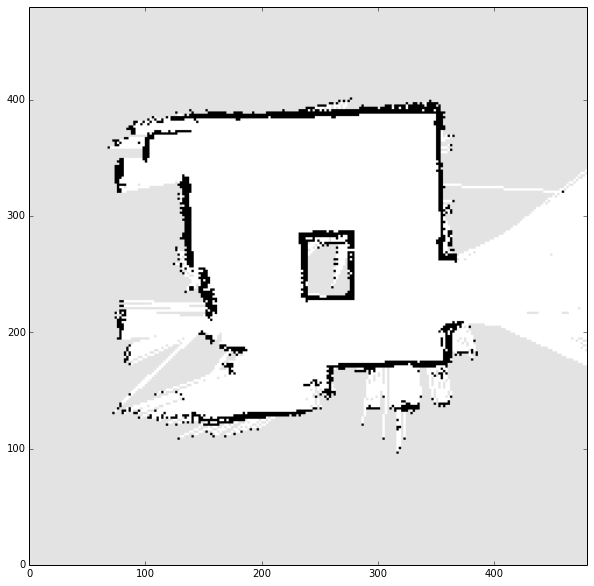

In [25]:
nb_draw_map(np_image)

In [26]:
# Inicializa as particulas
nb_initialize_particle_cloud()

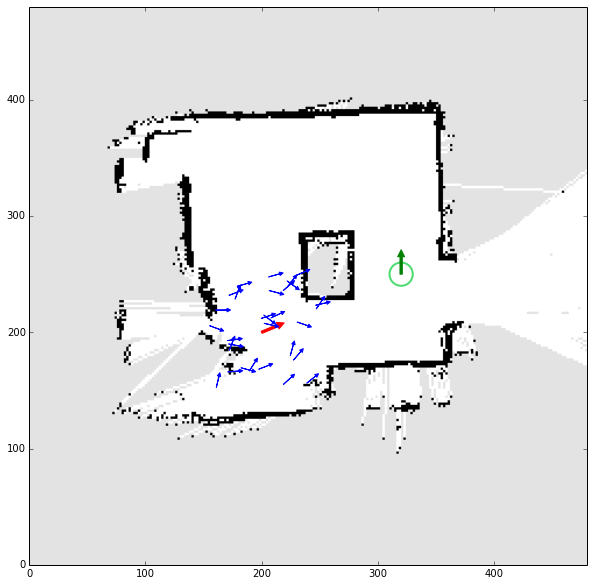

In [27]:
nb_draw_map(np_image, particles = particle_cloud, initial_position = initial_pose, pose=pose, robot=True)

## Occupancy field para o exemplo

In [28]:
# Obtemos o mapa. Esta etapa no projeto e'  com um cliente do servico MapServer
mapa = nb_create_ros_map(np_image)
occupancy_field = OccupancyField(mapa)





('Occurences of zero', 72836)
Using scikit-learn to compute nearest neighbors


In [29]:
# Criaremos um plot do occupancy_field
occupancy_image = nb_cria_occupancy_field_image(occupancy_field, np_image)

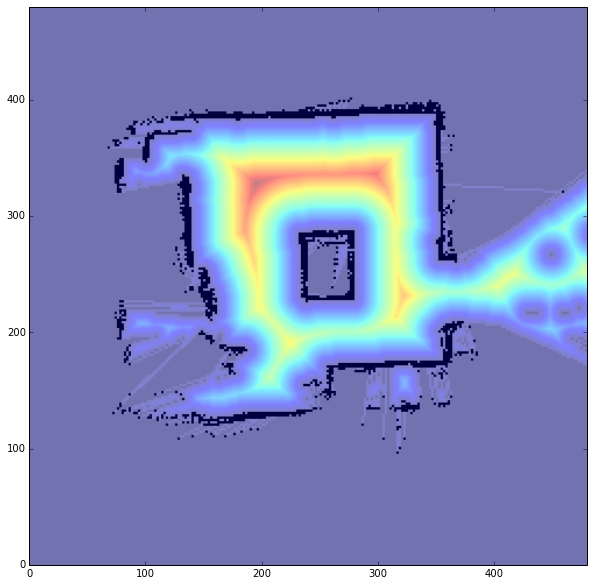

In [30]:
ax = nb_draw_map(np_image)
ax.imshow(occupancy_image, alpha=0.5)
#nb_draw_map(occupancy_image)

In [31]:
angles

array([ 0.        ,  0.8975979 ,  1.7951958 ,  2.6927937 ,  3.5903916 ,
        4.48798951,  5.38558741,  6.28318531])

# Simulacao da imagem do laser

Para simular a leitura **real** do robo, use *nb_simulate_lidar* passando a posicao do robo, os angulos do sensor e a np_image com o mapa

In [32]:
leituras, lidar_map = nb_simulate_lidar(pose, angles, np_image)


('Angle ', 1.5707963267948966)
('Hit for ', 320.0, '  ', 396.40000000000526, '  for angle ', 1.5707963267948966)
('Angle ', 2.4683942278205517)
('Hit for ', 146.9025097815818, '  ', 388.04064213152475, '  for angle ', 2.4683942278205517)
('Angle ', 3.3659921288462069)
('Hit for ', 275.54328720450894, '  ', 239.85304541159212, '  for angle ', 3.3659921288462069)
('Angle ', 4.2635900298718621)
('Hit for ', 281.47112396635885, '  ', 169.99396453026714, '  for angle ', 4.2635900298718621)
('Angle ', 5.1611879308975173)
('Hit for ', 360.09085749446444, '  ', 166.7504766058185, '  for angle ', 5.1611879308975173)
('Angle ', 6.0587858319231724)
('Hit for ', 460.3896193541823, '  ', 217.9569855102909, '  for angle ', 6.0587858319231724)
('Angle ', 6.9563837329488276)
('Hit for ', 364.0952956111943, '  ', 285.16482482483286, '  for angle ', 6.9563837329488276)
('Angle ', 7.8539816339744828)
('Hit for ', 320.0, '  ', 396.40000000000526, '  for angle ', 7.8539816339744828)


As leituras serao retornadas pela simulacao do lidar. Sao armazenadas na forma de um dicionario com angulo: valor da leitura

In [33]:
# As predicoes teoricas das leituras
leituras

{1.5707963267948966: 164.59647626847908,
 2.4683942278205517: 153.8440769090575,
 3.3659921288462069: 81.74350127074322,
 4.2635900298718621: 171.35343591536179,
 5.1611879308975173: 175.41949720598336,
 6.0587858319231724: 108.15729286552988,
 6.9563837329488276: 49.49747468305833,
 7.8539816339744828: 164.59647626847908}

# Laser simulado sobre occupancy field

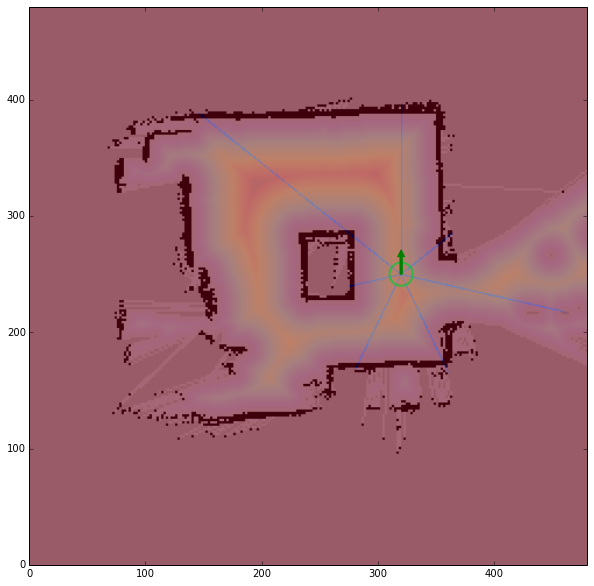

In [34]:
ax = nb_draw_map(np_image, pose=pose, robot=True)
ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

In [35]:
pose[1]=200
pose[2] = math.radians(180)

In [36]:
leituras, lidar_map = nb_simulate_lidar(pose, angles, np_image)


('Angle ', 3.1415926535897931)
('Hit for ', 77.59999999999928, '  ', 200.0, '  for angle ', 3.1415926535897931)
('Angle ', 4.0391905546154483)
('Hit for ', 291.94295891635676, '  ', 164.8175832889386, '  for angle ', 4.0391905546154483)
('Angle ', 4.9367884556411035)
('Hit for ', 335.08691932223803, '  ', 133.8998875540725, '  for angle ', 4.9367884556411035)
('Angle ', 5.8343863566667586)
('Hit for ', 364.32766830080027, '  ', 178.65292003541504, '  for angle ', 5.8343863566667586)
('Angle ', 6.7319842576924138)
('Hit for ', 510.2846249009963, '  ', 291.636245701633, '  for angle ', 6.7319842576924138)
('Angle ', 7.629582158718069)
('Hit for ', 354.0457028953159, '  ', 349.1639705638187, '  for angle ', 7.629582158718069)
('Angle ', 8.5271800597437242)
('Hit for ', 273.9864526228251, '  ', 257.6991634061406, '  for angle ', 8.5271800597437242)
('Angle ', 9.4247779607693793)
('Hit for ', 77.59999999999928, '  ', 200.0, '  for angle ', 9.4247779607693793)


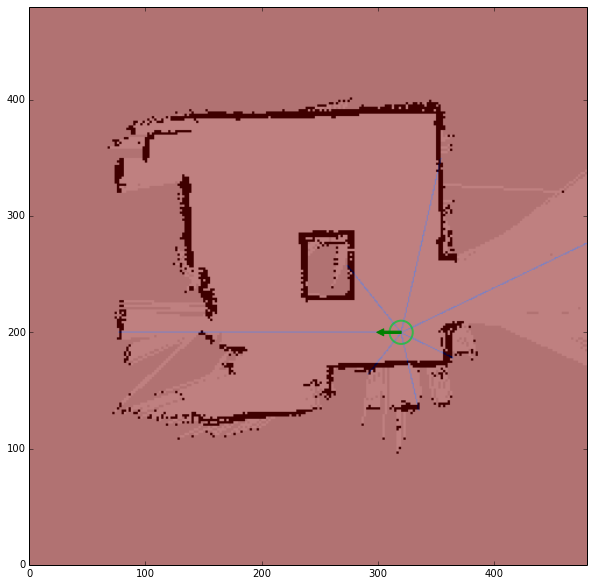

In [37]:
ax = nb_draw_map(np_image, pose=pose, robot=True)
#ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

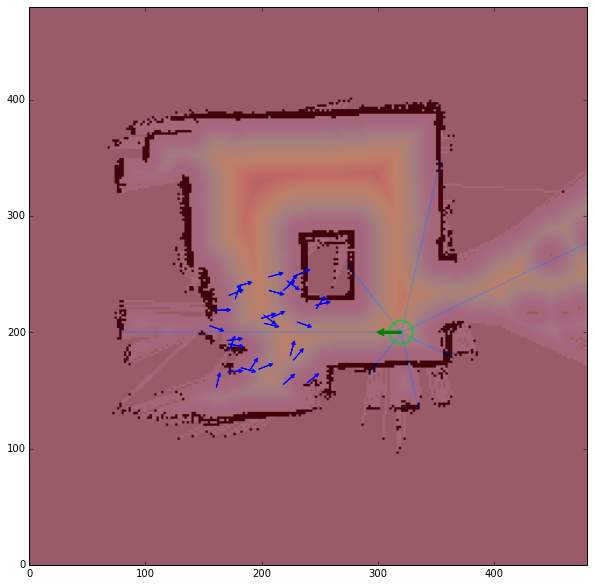

In [38]:
ax = nb_draw_map(np_image, pose=pose, robot=True, particles=particle_cloud)
ax.imshow(occupancy_image, alpha=0.2)
ax.imshow(lidar_map, alpha=0.5)

## Sugestao de atividade:

Coloque os seguintes passos num loop:

- Mova o robo alterando a variavel *pose*

- Atualize as particulas com odometria

- Calcule a verossimilanca das particulas usando o OccupancyField - **note que e'  a mesma classe usada no ROS**

- Reamostre as particulas

Use as funcoes de plot abundantemente ao longo do desenvolvimento